### Pytorch를 이용한 키(height),성별(Gender),나이(Age) -> 몸무게(weight) 
### 다중 선형 회귀 학습
* 키, 성별, 나이 3가지 입력을 바탕으로 몸무게를 예측할 수 있도록 선형 회귀 코드를 작성하였다.
* 국민건강보험 2022년 건강검진 데이터를 사용하였다.

* 다중 선형 회귀에서는, 기존의 단일 입력 데이터였던 키 정보 뿐만이 아니라, 나이와 성별 데이터까지 입력으로 수집한다. 이에 따라 동일한 입력 데이터인 키: 165cm와 나이 52세 여성의 예상 몸무게가 단일 입력 선형회귀 모델에 비해 차이가 발생하는 것을 확인할 수 있다. 나이와 성별이라는 데이터가 추가되면서 좀 더 정밀하게 예측되었음을 추측할 수 있다. 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# CSV 파일 불러오기
file_path = "health_data_korea.CSV"  # 파일 경로
df = pd.read_csv(file_path)

# 필요한 열 선택 (키, 나이, 성별, 몸무게 데이터)
df_filtered = df[['Height (5cm Intervals)', 'Age Group Code (5-Year Intervals)', 'Gender', 'Weight (5kg Intervals)']].dropna().iloc[:300]
df_filtered.rename(columns={'Height (5cm Intervals)': 'Height', 'Age Group Code (5-Year Intervals)':'Age','Weight (5kg Intervals)': 'Weight'}, inplace=True)

# 성별(Gender) 인코딩 (여성: 0, 남성: 1)
df_filtered['Gender'] = df_filtered['Gender'].map({1: 1, 2: 0})

# 나이(Age) 변환 (범주값을 중간값으로 매핑)
age_mapping = {
    9: 42, 10: 47, 11: 52, 12: 57, 13: 62, 14: 67, 15: 72, 16: 77, 17: 82, 18: 87
}
df_filtered['Age'] = df_filtered['Age'].map(age_mapping)

# PyTorch 텐서 변환
x_train = torch.tensor(df_filtered[['Height', 'Age', 'Gender']].values, dtype=torch.float32)  # 입력: 키, 나이, 성별
y_train = torch.tensor(df_filtered['Weight'].values, dtype=torch.float32).reshape(-1, 1)  # 출력: 몸무게

# 데이터 정규화 (표준화)
x_mean, x_std = x_train.mean(dim=0), x_train.std(dim=0)
y_mean, y_std = y_train.mean(), y_train.std()

x_train = (x_train - x_mean) / x_std  # 입력 데이터 정규화
y_train = (y_train - y_mean) / y_std  # 출력 데이터 정규화

Epoch [50/500], Loss: 0.6195
Epoch [100/500], Loss: 0.5846
Epoch [150/500], Loss: 0.5811
Epoch [200/500], Loss: 0.5804
Epoch [250/500], Loss: 0.5801
Epoch [300/500], Loss: 0.5800
Epoch [350/500], Loss: 0.5799
Epoch [400/500], Loss: 0.5798
Epoch [450/500], Loss: 0.5798
Epoch [500/500], Loss: 0.5798


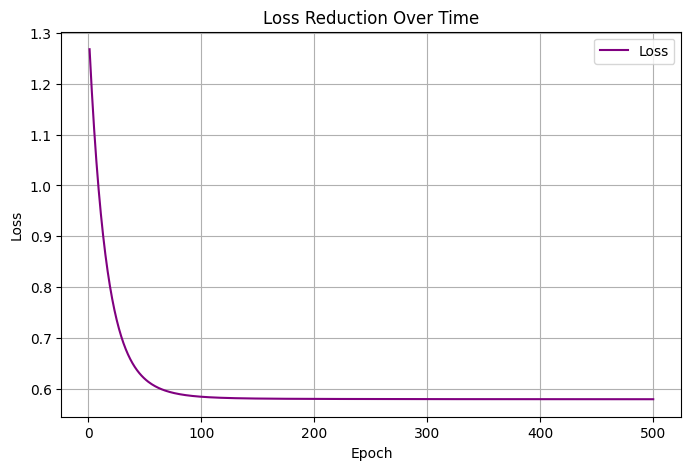

In [ ]:
# 다중 선형 회귀 모델 정의
class MultipleLinearRegressionModel(nn.Module):
    def __init__(self):
        super(MultipleLinearRegressionModel, self).__init__()
        self.linear = nn.Linear(3, 1)  
        # 입력 3개(키, 나이, 성별) → 출력 1개(몸무게)

    def forward(self, x):
        return self.linear(x)

model = MultipleLinearRegressionModel()

# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 학습 루프 실행
num_epochs = 500
loss_values = []  # 손실 값 저장
for epoch in range(num_epochs):
    y_pred = model(x_train)  # 모델 예측
    loss = criterion(y_pred, y_train)  # 손실 계산
    loss_values.append(loss.item())
    
    optimizer.zero_grad()  # 기울기 초기화
    loss.backward()  # 역전파
    optimizer.step()  # 가중치 업데이트
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 손실 값 그래프
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_values, label="Loss", color="purple")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Reduction Over Time")
plt.legend()
plt.grid(True)
plt.show()



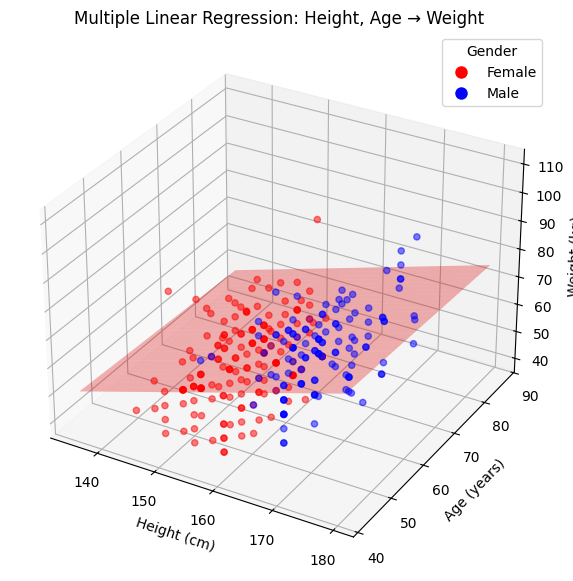

In [ ]:
# 3D 시각화 (Height, Age → Weight)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 실제 데이터
scatter = ax.scatter(df_filtered['Height'], df_filtered['Age'], df_filtered['Weight'], color=['red' if g == 0 else 'blue' for g in df_filtered['Gender']], alpha=0.5)

# 컬러바 추가 (성별 구분)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Female', markerfacecolor='red', markersize=10)
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Male', markerfacecolor='blue', markersize=10)

# 모델 예측 데이터 생성
height_range = np.linspace(df_filtered['Height'].min(), df_filtered['Height'].max(), 30)
age_range = np.linspace(df_filtered['Age'].min(), df_filtered['Age'].max(), 30)
height_grid, age_grid = np.meshgrid(height_range, age_range)

x_test_grid = torch.tensor(np.c_[height_grid.ravel(), age_grid.ravel(), np.ones_like(age_grid.ravel())], dtype=torch.float32)
x_test_grid = (x_test_grid - x_mean) / x_std  # 정규화 적용
y_pred_grid = model(x_test_grid).detach().numpy().reshape(height_grid.shape)  # 예측

y_pred_grid = y_pred_grid * y_std.item() + y_mean.item()  # 역정규화

# 회귀 평면 시각화
ax.plot_surface(height_grid, age_grid, y_pred_grid, color='red', alpha=0.3)

ax.set_xlabel("Height (cm)")
ax.set_ylabel("Age (years)")
ax.set_zlabel("Weight (kg)")
ax.set_title("Multiple Linear Regression: Height, Age → Weight")
ax.legend(handles=[red_patch, blue_patch], title='Gender', loc='upper right')
plt.show()


In [ ]:
# 학습된 모델로 예측 수행 (예: 키 165cm, 나이 52, 성별 여성(0)일 때 몸무게 예측)
x_test = torch.tensor([[165.0, 52, 0]], dtype=torch.float32)  # 나이 50~54세 → 52
x_test = (x_test - x_mean) / x_std  # 입력 데이터 정규화

y_test_pred = model(x_test)
y_test_pred = y_test_pred * y_std + y_mean  # 역정규화 (원래 단위로 변환)

# 결과 출력
print(f"키 165cm, 나이 50~54세(평균 52), 성별 여성의 예상 몸무게: {y_test_pred.item():.2f}kg")

키 165cm, 나이 50~54세(평균 52), 성별 여성의 예상 몸무게: 64.05kg
